# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

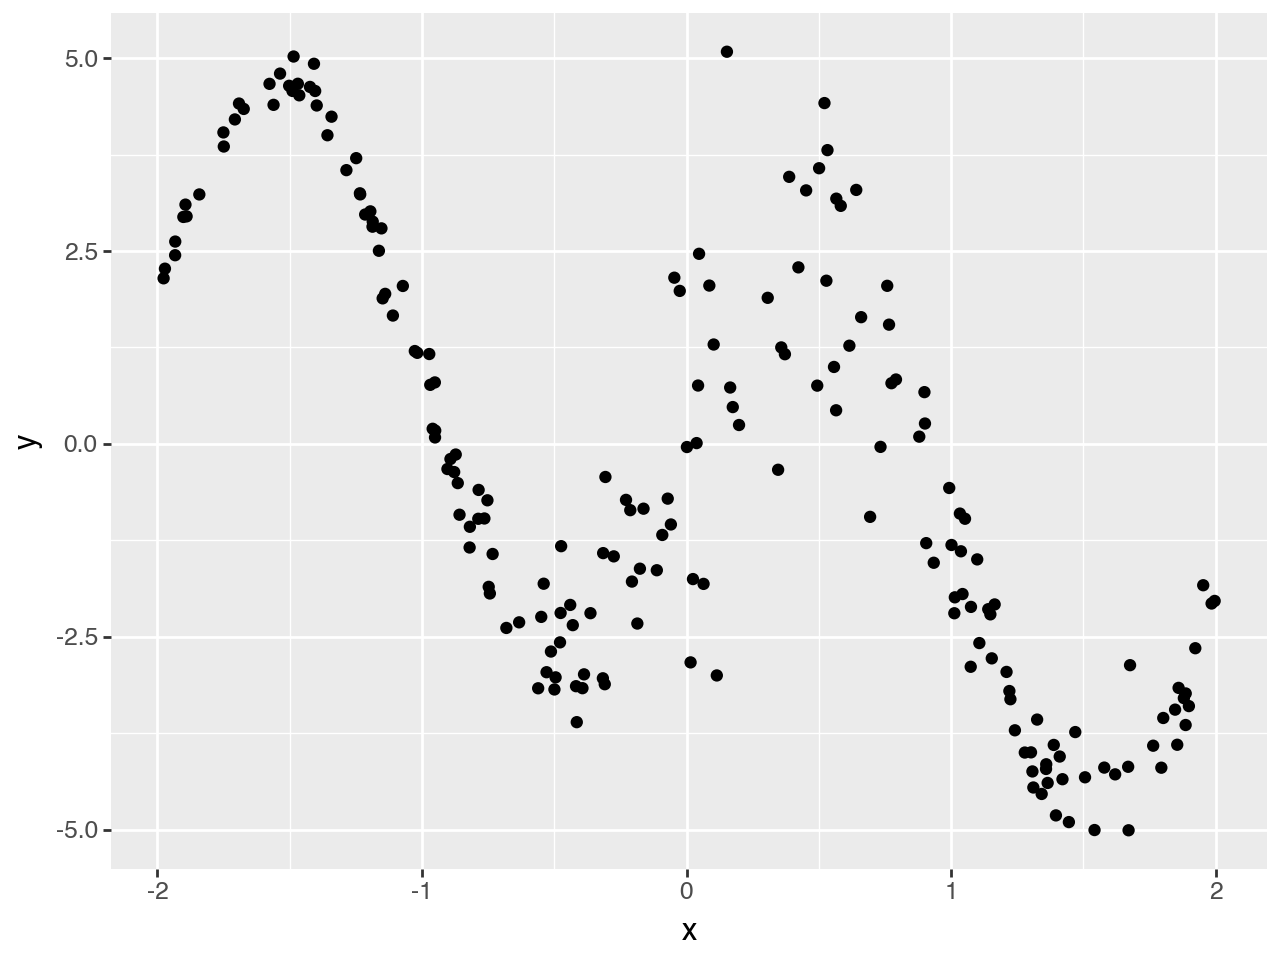

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [5]:
tb = gam.TermBuilder.from_df(df)

In [6]:
loc += tb.ps("x")
scale += tb.ps("x")

### Build and plot model

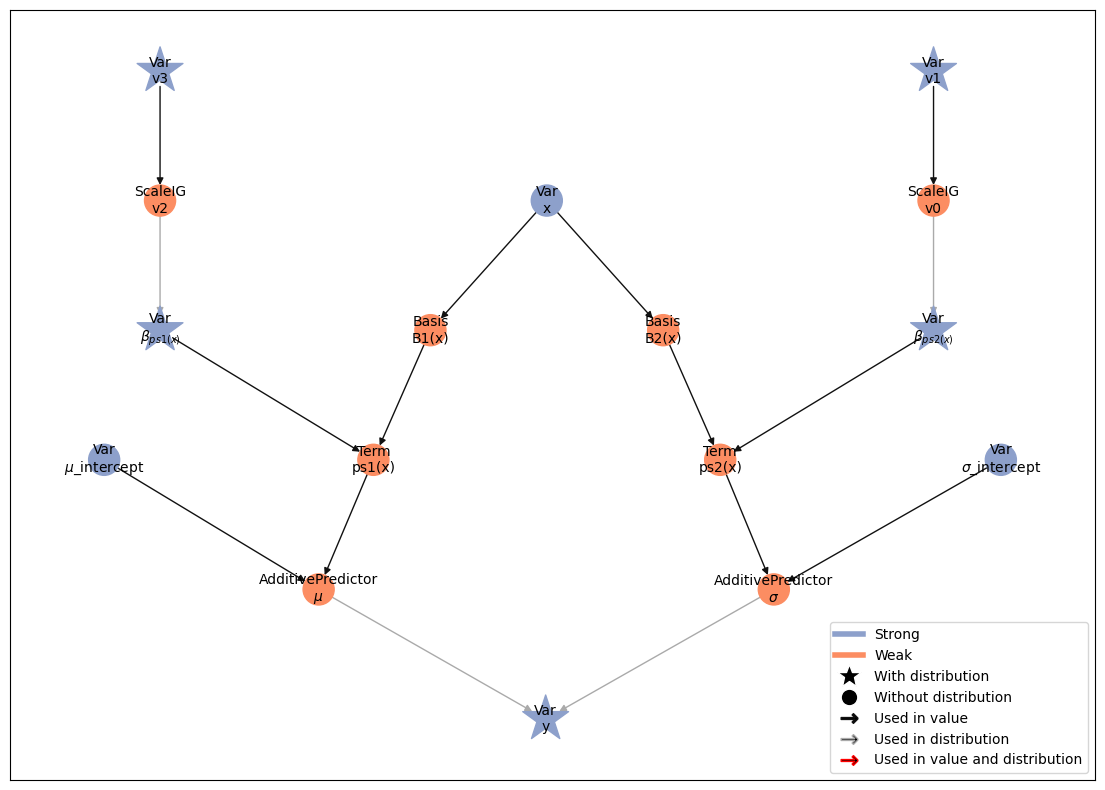

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{ps2(x)}$', 'v1', '$\\mu$_intercept', '$\\beta_{ps1(x)}$', 'v3'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.79chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1481.56chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_04 -0.246696  0.409834 -0.922989 -0.237257   
                   (1,)   kernel_04 -0.017330  0.373262 -0.623883 -0.021947   
                   (2,)   kernel_04  0.396498  0.385439 -0.201457  0.384860   
                   (3,)   kernel_04  0.172051  0.368857 -0.429433  0.158230   
                   (4,)   kernel_04  0.141127  0.342888 -0.400594  0.136654   
                   (5,)   kernel_04  0.163616  0.323656 -0.353215  0.161188   
                   (6,)   kernel_04  0.008071  0.315860 -0.504296  0.002753   
                   (7,)   kernel_04 -0.066947  0.284494 -0.539084 -0.065627   
                   (8,)   kernel_04  0.068026  0.279009 -0.381456  0.064127   
                   (9,)   kernel_04  0.107613  0.243067 -0.283092  0.104748   
                   (10,)  kernel_04  0.138718  0.229558 -0.243772  0.147041   
                   (11,)  kernel_04 -0.119934  0.197758 -0.449217 -0.117995   
                   (12,)  kernel_04  0.313209  0.172894  0.030360  0.314224   
                   (13,)  kernel_04 -0.048207  0.137305 -0.268507 -0.052458   
                   (14,)  kernel_04  1.348630  0.105938  1.179858  1.347347   
                   (15,)  kernel_04  0.035876  0.070612 -0.078095  0.034949   
                   (16,)  kernel_04  0.120204  0.039864  0.055657  0.120277   
                   (17,)  kernel_04  0.014311  0.016572 -0.012534  0.014194   
                   (18,)  kernel_04 -0.316049  0.062313 -0.418292 -0.316102   
$\beta_{ps2(x)}$   (0,)   kernel_01 -0.005746  0.085698 -0.144991 -0.004811   
                   (1,)   kernel_01  0.009927  0.085072 -0.122448  0.008176   
                   (2,)   kernel_01 -0.001632  0.083044 -0.135914 -0.002092   
                   (3,)   kernel_01  0.001432  0.080819 -0.127256  0.001274   
                   (4,)   kernel_01 -0.014725  0.082076 -0.155719 -0.012244   
                   (5,)   kernel_01  0.006606  0.081991 -0.123106  0.004312   
                   (6,)   kernel_01  0.017127  0.081847 -0.110282  0.014129   
                   (7,)   kernel_01 -0.031156  0.082130 -0.178457 -0.025066   
                   (8,)   kernel_01  0.025144  0.079009 -0.100000  0.022843   
                   (9,)   kernel_01  0.000742  0.074713 -0.121522 -0.000271   
                   (10,)  kernel_01 -0.007041  0.071504 -0.121512 -0.007290   
                   (11,)  kernel_01 -0.004810  0.066959 -0.115555 -0.005052   
                   (12,)  kernel_01  0.079324  0.067755 -0.021960  0.075350   
                   (13,)  kernel_01 -0.081727  0.059669 -0.187181 -0.078733   
                   (14,)  kernel_01  0.055648  0.050093 -0.024273  0.054406   
                   (15,)  kernel_01  0.081929  0.036390  0.023797  0.081363   
                   (16,)  kernel_01 -0.003171  0.022116 -0.039205 -0.003077   
                   (17,)  kernel_01 -0.043651  0.009766 -0.059198 -0.043817   
                   (18,)  kernel_01  0.142726  0.038538  0.078450  0.142953   
$\mu$_intercept    ()     kernel_03 -0.322027  0.057566 -0.416540 -0.323366   
$\sigma$_intercept ()     kernel_00 -0.631354  0.052999 -0.716909 -0.632949   
v1                 ()     kernel_02  0.007023  0.005351  0.002199  0.005616   
v3                 ()     kernel_05  0.198344  0.094172  0.096147  0.177617   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\beta_{ps1(x)}$   (0,)   0.415477         4000  3217.065906  3729.266595   
                   (1,)   0.579623         4000  3592.408687  3599.973890   
                   (2,)   1.060297         4000  3223.890967  3594.030521   
                   (3,)   0.784633         4000  3528.303219  3581.382471   
                   (4,)   0.712978       

### MCMC trace plots

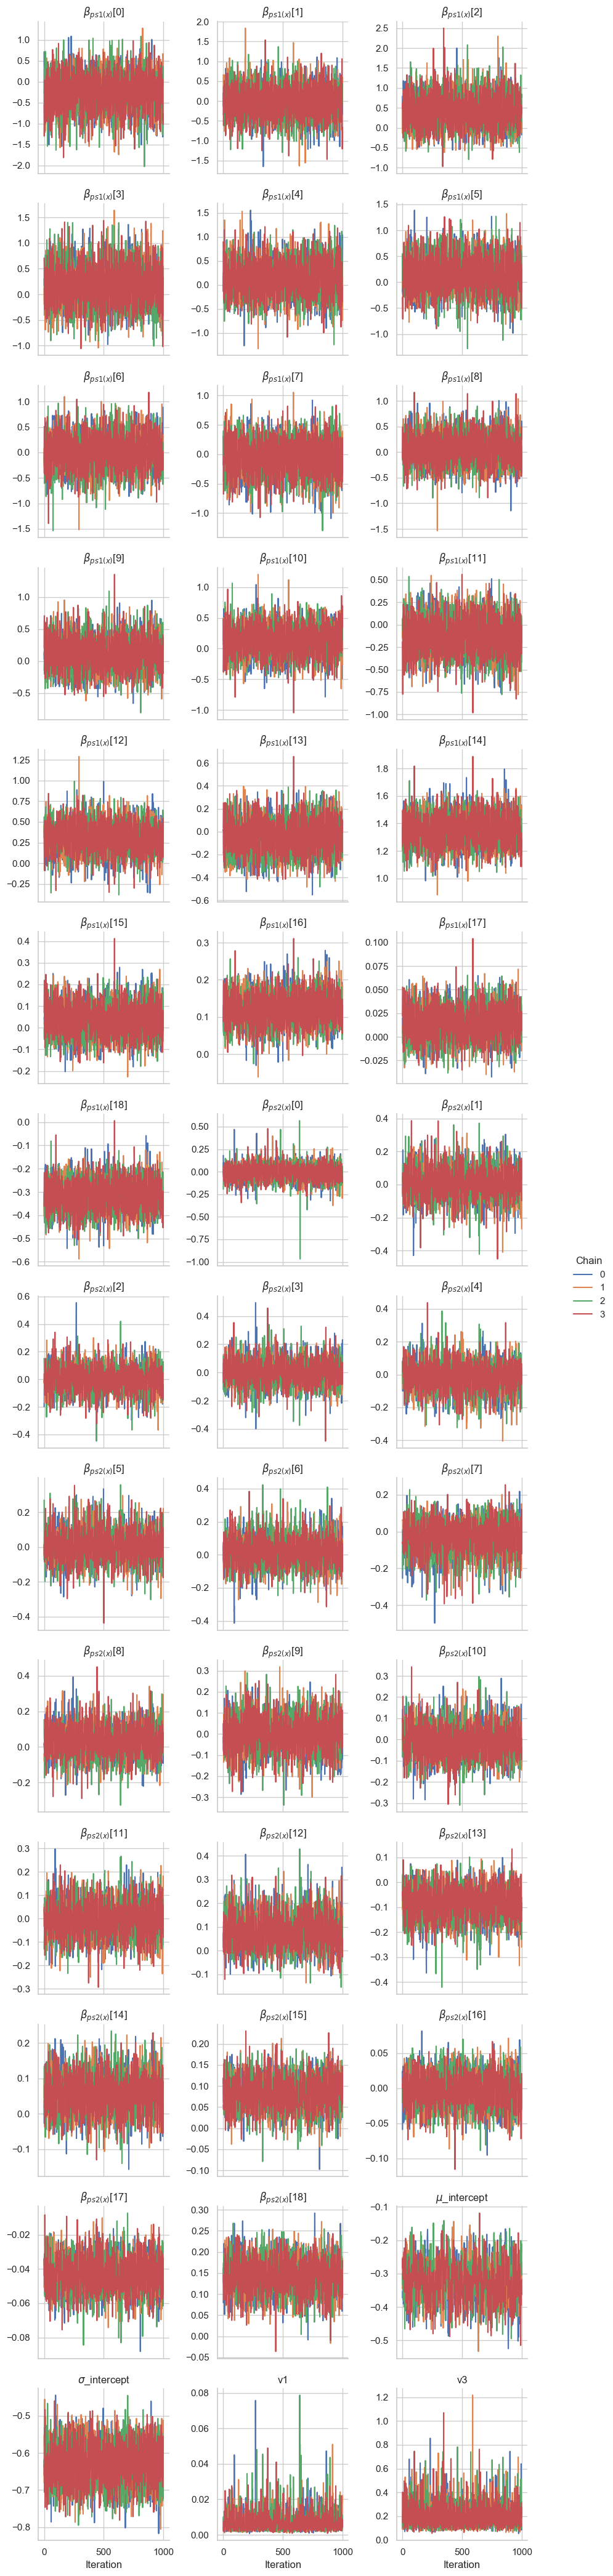

In [10]:
gs.plot_trace(results)

## Predictions

In [11]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [12]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ps1(x)", "ps2(x)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [13]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.190968,0.004075,0.063838,1.000048,3566.451823,3756.189647,0.001069,0.000921,2.090080,2.190676,2.294553,2.087022,2.290901,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.315030,0.002867,0.053542,0.999795,3494.584724,3634.755497,0.000904,0.000791,2.229567,2.314937,2.401615,2.226767,2.397487,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,2.437181,0.002122,0.046062,0.999938,3368.879853,3721.598334,0.000791,0.000696,2.364797,2.436906,2.511454,2.361784,2.508329,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,2.557314,0.001723,0.041510,1.000517,3086.608871,3571.147329,0.000738,0.000631,2.491034,2.557740,2.624106,2.490915,2.623650,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,2.675332,0.001575,0.039692,1.001174,2835.465114,3554.343704,0.000736,0.000592,2.611658,2.675618,2.739603,2.612090,2.739954,-1.923554


### Plot fitted functions

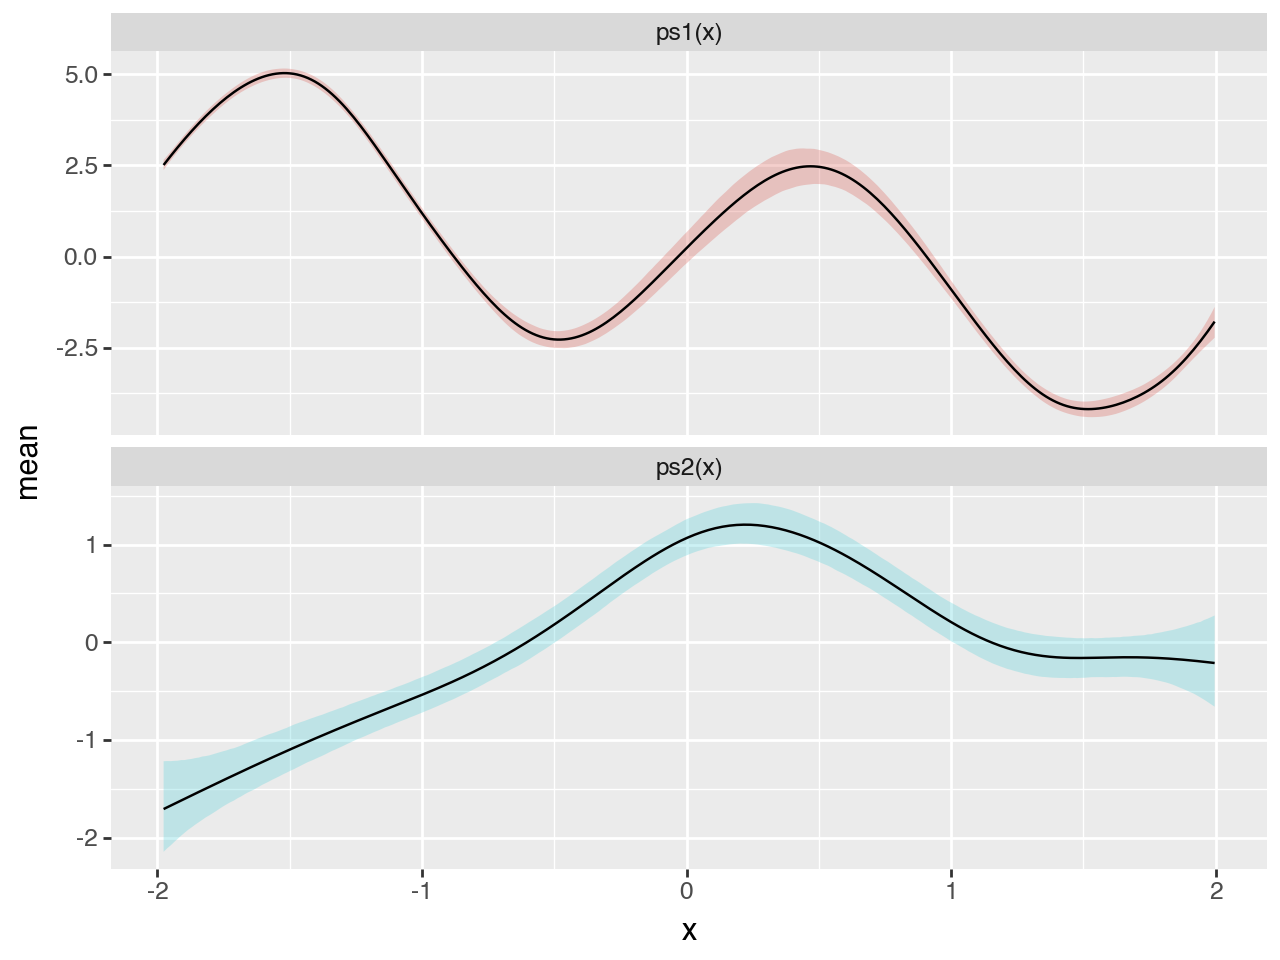

In [14]:
select = predictions_summary["variable"].isin(["ps1(x)", "ps2(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

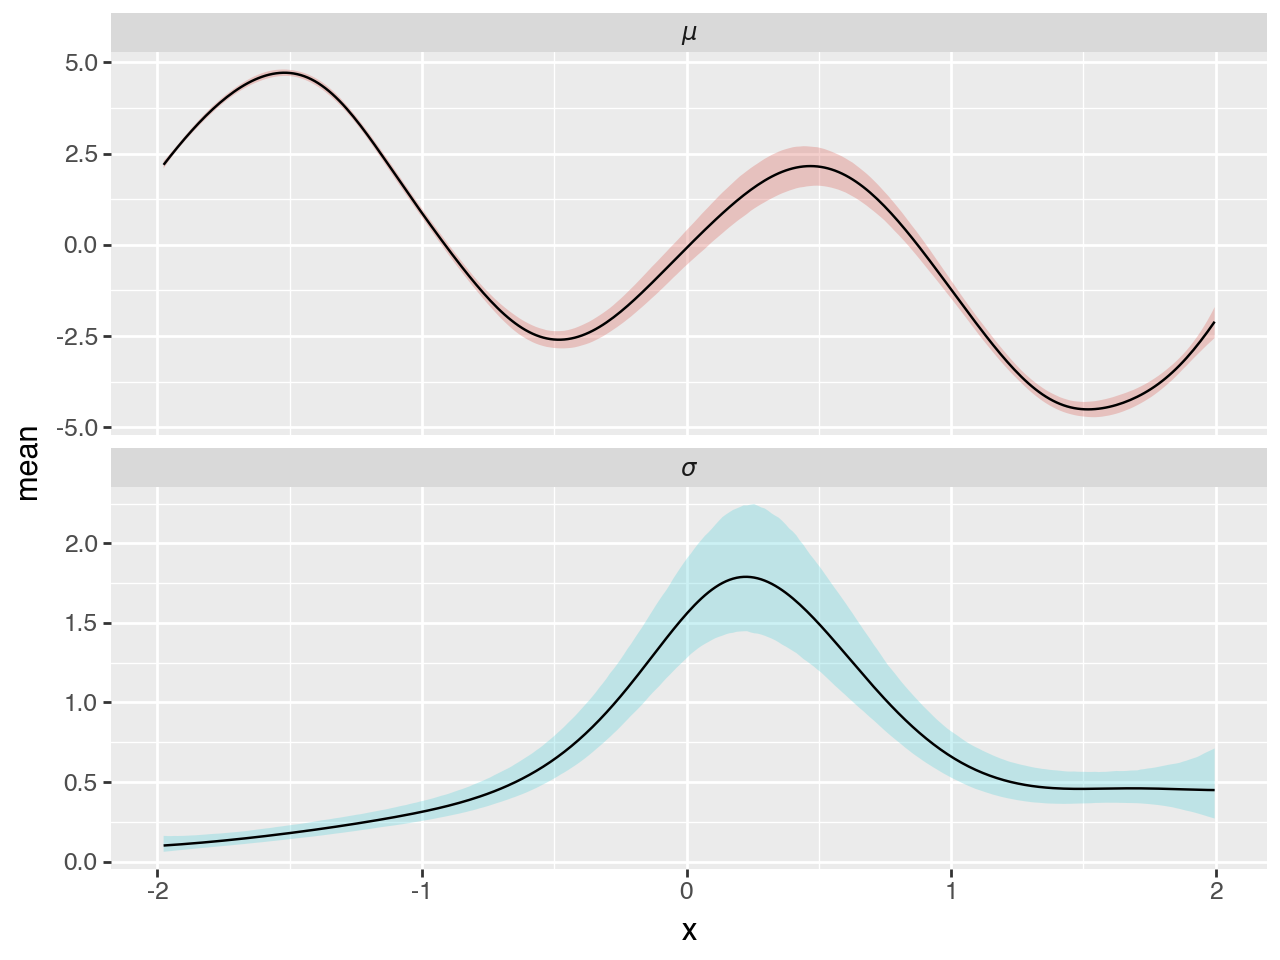

In [15]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

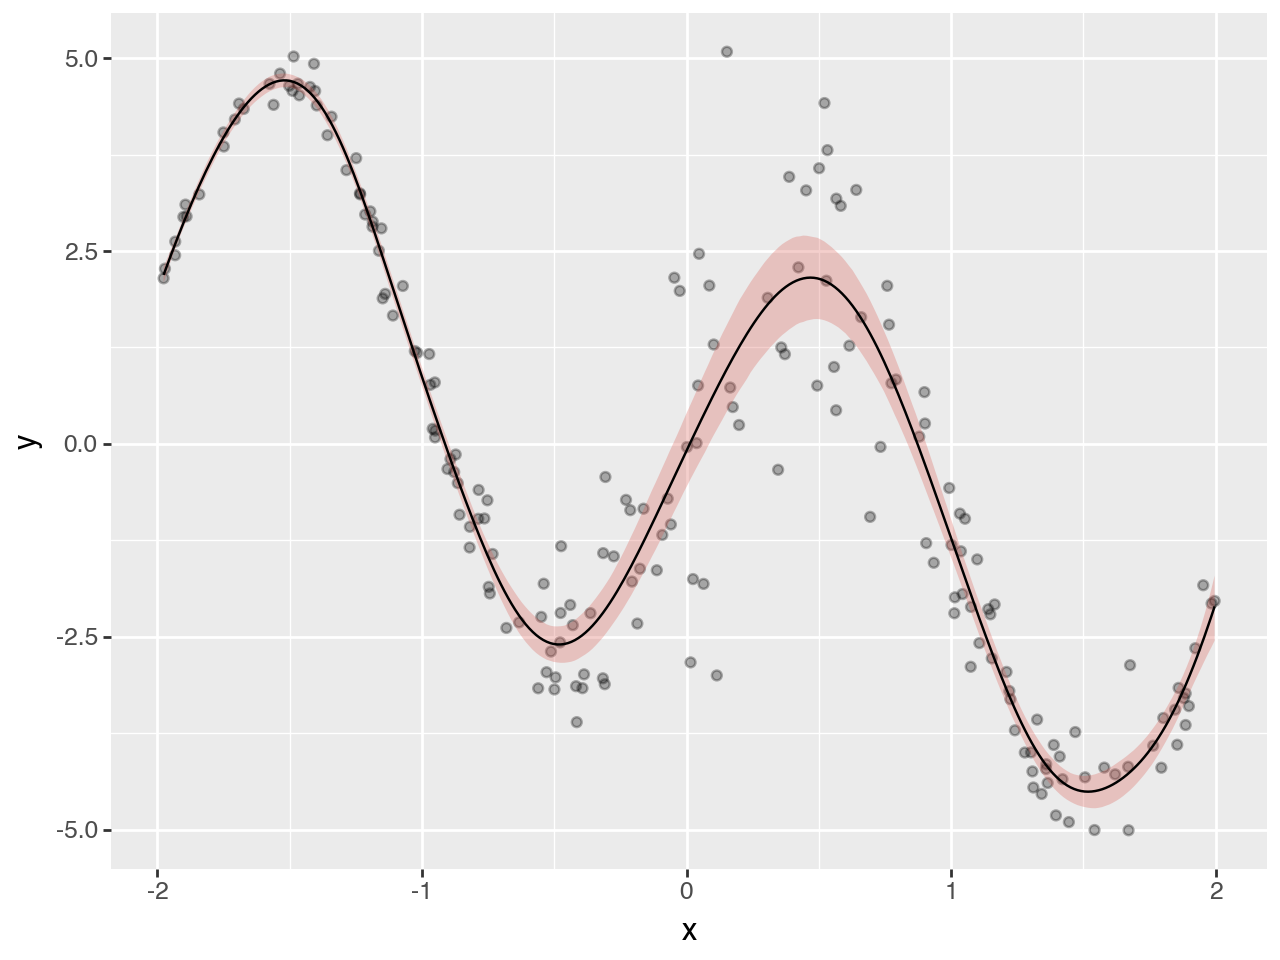

In [16]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [17]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.190968,0.100910,2.090058,2.291878
1,-1.963415,2.315030,0.102350,2.212680,2.417380
2,-1.950128,2.437181,0.103839,2.333343,2.541020
3,-1.936841,2.557314,0.105376,2.451937,2.662690
4,-1.923554,2.675332,0.106963,2.568369,2.782295
...,...,...,...,...,...
295,1.942956,-2.635372,0.450916,-3.086288,-2.184456
296,1.956243,-2.508756,0.450430,-2.959186,-2.058326
297,1.969530,-2.378215,0.450014,-2.828229,-1.928200
298,1.982817,-2.243946,0.449682,-2.693628,-1.794264


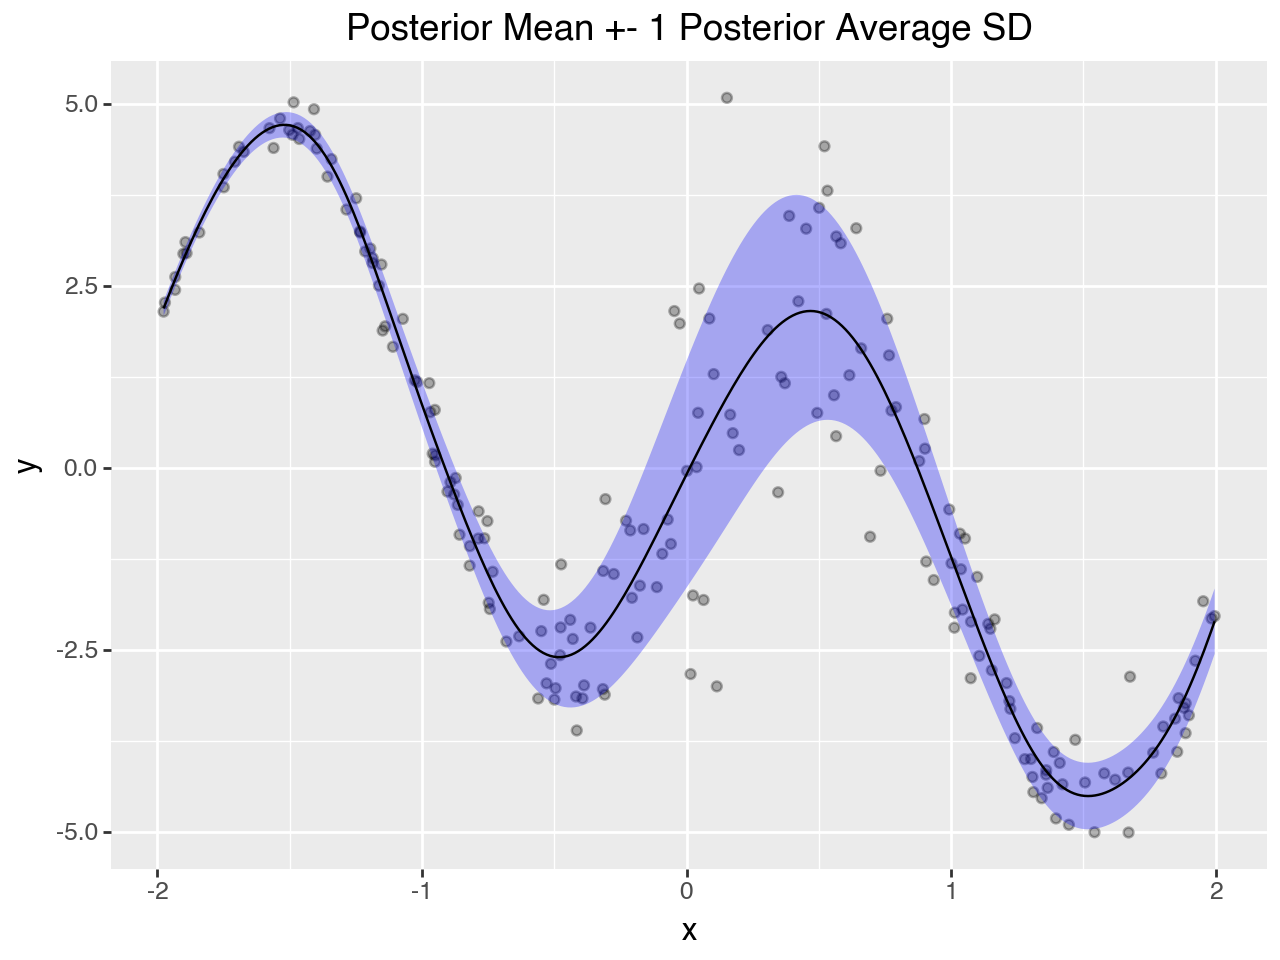

In [18]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [19]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [20]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [21]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

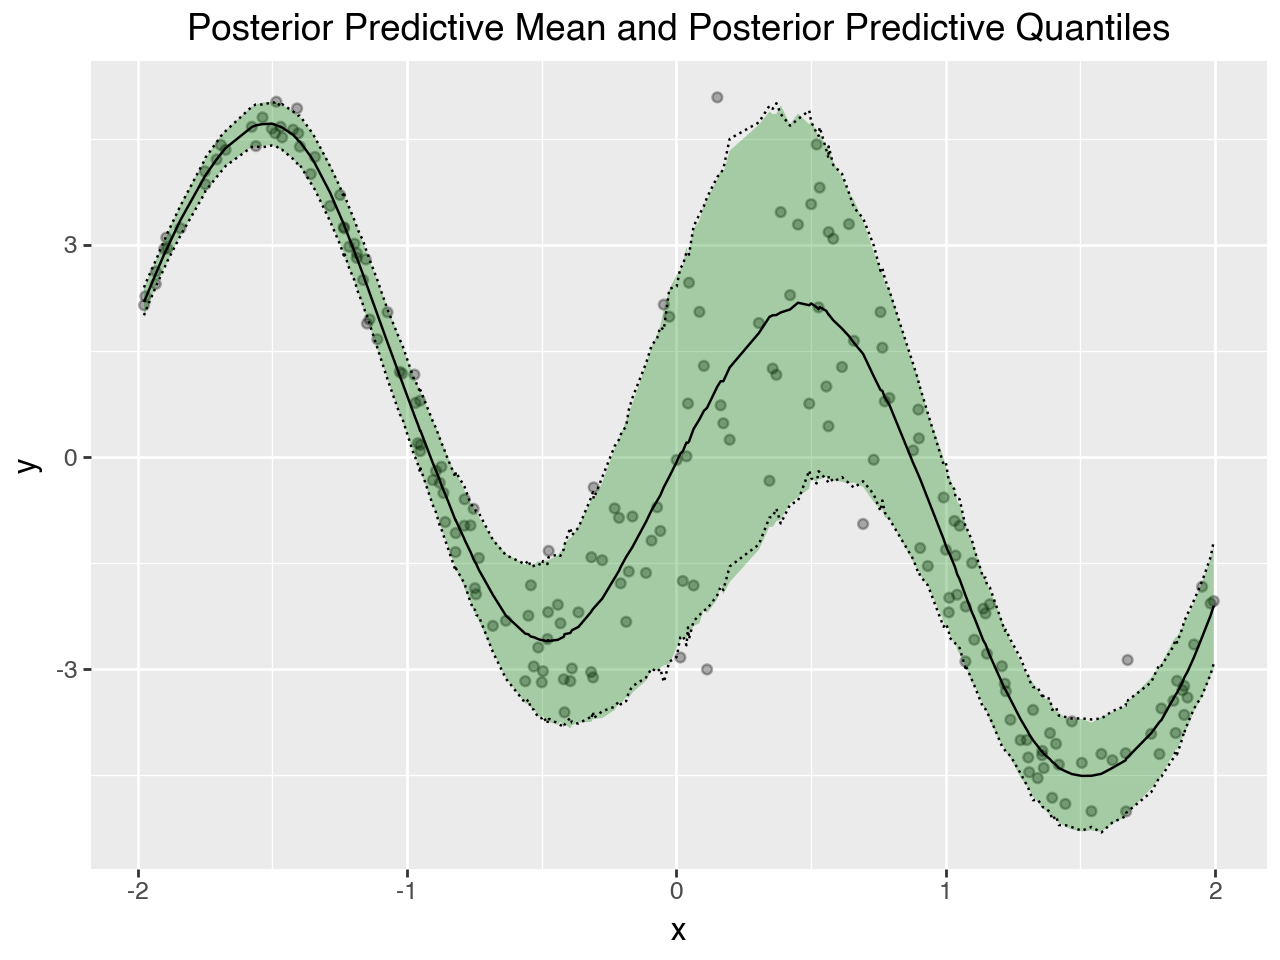

In [22]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

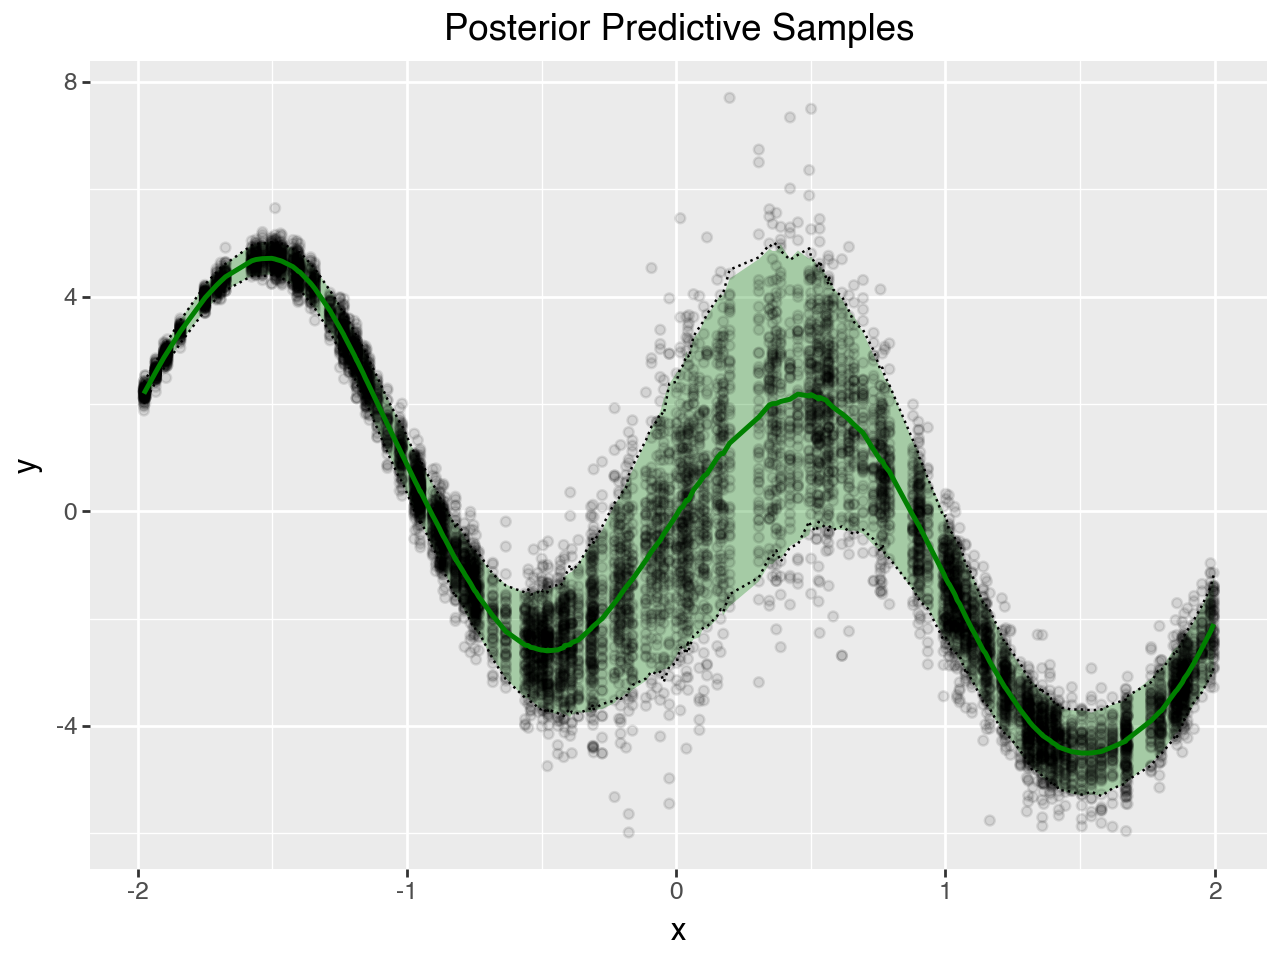

In [23]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)